# Computing MSR from fortranic spiral tip location data
Tim Tyree<br>
6.25.2022

In [1]:
import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

In [2]:
os.chdir(nb_dir)
from lib import *

In [3]:
import cupy, cudf
from lib.rapids_func import *

In [4]:
import seaborn as sns
import matplotlib.ticker as mtick

In [5]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [6]:
import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

# define module

In [7]:
#TODO: move to lib.utils.parquetio.py
import shutil, os, pandas
def save_df_to_parquet_by(df,folder_parquet,by='trial_num',
                          compression='snappy',index=None,
                          **kwargs):
    """save_df_to_parquet_by groups pd.DataFrame instance, df by by='trial_num', 
    and then saves each group into a separate parquet file in 
    
    options for compression: {'snappy', 'gzip', 'brotli', None}, default 'snappy'
    see df.to_parquet? for details on compression
    
    Example Usage:
log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    """
    #clear cache before saving into it
    if os.path.exists(folder_parquet):
        shutil.rmtree(folder_parquet,ignore_errors=True)
    #save to parquet
    df.to_parquet(folder_parquet,index=index,
                     compression=compression,
                      partition_cols=[by])
    return True

def load_parquet_by_trial_num(trial_num,folder_parquet,reset_index=True,**kwargs):
    """
    Example Usage:
log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
g=load_parquet_by_trial_num(trial_num=639,folder_parquet=log_folder_parquet)
    """
    log_dir_parquet=os.path.join(folder_parquet,f"{trial_num=}")
    df=pd.read_parquet(log_dir_parquet)
    df['trial_num']=trial_num
    if reset_index:
        df.reset_index(inplace=True)
    #set index dtyp
    #df.index = df.index.map(str)
    #df.index = df.index.map(np.int64)
    df.index = df.index.astype(np.int64)
    return df

In [8]:
import re

def strip_line_to_csv(line):
    """
    Example Usage:
str_csv=strip_line_to_csv(line)
value_tuple=eval(str_csv)
    """
    str_csv=re.sub(r'\s+', ',', line.strip())
    return str_csv

In [9]:
from itertools import zip_longest
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [10]:
def comp_moving_avg_pbc_trajectories_cu(traj,navg1,width,height,t_col='t',pid_col='particle',printing=True,**kwargs):
    """comp_moving_avg_pbc_trajectories_cu returns a cudf.DataFrame instance that uses the gpu to smooth the trajectories using a moving average of window length, navg1, respecting pbc.
    traj is a pandas.DataFrame or a cudf.DataFrame instance with fields 'x','y' containing location on a square grid with periodic boundary conditions (pbc).
    t_col is the field containing time.
    the particle is index by pid_col.
    
    Example Usage:
df=comp_moving_avg_pbc_trajectories_cu(traj,navg1,width,height)#,t_col='t',pid_col='particle',printing=True)#,**kwargs)
    """
    #GOAL: compute smoothed trajectories, as before
    # t_col='t'
    #     df=pd.read_csv(input_fn)
    #     DT=np.around(get_DT(df, t_col=t_col, pid_col=pid_col),5);print(f"DT={DT}")
    #     # ds=5 #cm
    #     # DS=ds/width
    # #     width=200
    #     height=width
    # use_drop_shorter_than=True
    # # drop_shorter_than=50 #ms
    # drop_shorter_than=10 #ms
    #     tmin=100.#ms
    #     pid_col='particle'
    #DONE: see if the gpu-accelerated version works, as before. yes.
    #df=cudf.read_csv(input_fn)
    df=cudf.DataFrame(traj)
    col_keep_lst=['x','y',pid_col,t_col]

    #sort by particle and then by time
    df=df.sort_values([pid_col, t_col], ascending=True).copy()
    df=apply_unwrap_xy_trajectories_pbc(df,t_col=t_col,pid_col=pid_col,width=width,height=height)
    df=apply_moving_avg_xy_trajectories(df,t_col=t_col,pid_col=pid_col,navg1=navg1,x_col='x_unwrap',y_col='y_unwrap')
    # df=apply_unwrap_xy_trajectories_pbc_serial(df,t_col=t_col,pid_col=pid_col,width=width,height=height)
    # df=apply_moving_avg_xy_trajectories_serial(df,t_col=t_col,pid_col=pid_col,navg1=navg1,x_col='x_unwrap',y_col='y_unwrap')
    #compute rewrapped coordinates
    df['x']=df['x_unwrap']-df['dx_unwrap']
    df['y']=df['y_unwrap']-df['dy_unwrap']
    #CONFIRMED: by increasing navg1, I can decrease the max displacement for all particles.
    #DONE: add unique identifier for whole trial that is unique accross different csv files
    #add unique identifier for each particle that is unique accross different csv files
    # fn = os.path.basename(input_fn)
    # event_id_int=float('1'+(''.join(re.findall(r'-?\d+\d*',fn))))
#     df['event_id_int']= int(trial_num) #int(event_id_int)
    # col_keep_lst=['x','y',t_col,pid_col,'event_id_int',"dx_unwrap","dy_unwrap"]
    # df=df[col_keep_lst].copy()
    return df

In [11]:
# type(og_stdout)

In [12]:
# og_stdout.

In [494]:
def copy_df_as_pandas(df):
    """copy_df_as_pandas takes pandas.DataFrame and cudf.DataFrame instances alike and returns a copy of the df as a pandas.DataFrame (perhaps useful good for saving)."""
    if str(type(df))=="<class 'cudf.core.dataframe.DataFrame'>":
            df_=df.to_pandas()
    else: #if str(type(dfr))=="<class 'pandas.core.frame.DataFrame'>":
        df_=df.copy()
    return df_

In [13]:
#used in analysis for tshift_tare_routine and for trajectories
# import os, sys
class HiddenPrints:
    """
    Example Usage:
og_stdout=sys.stdout
with HiddenPrints(): #  (og_stdout=og_stdout):  #kwargs are not for with statements in py39...
    traj = compute_track_tips_pbc(df_log_local, mem=mem, sr=sr, width=width, height=height)
    
    Example Usage:
 with HiddenPrints():
    retval=tshift_tare_routine(df_R,navg2,max_num_groups=9e9,plotting=False,npartitions=10,R_col='R_nosavgol',printing=True)
    """
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [398]:
def align_timeseries_simple(dfr,df_pairs,
                            P_col='index_pairs',
                            R_col='R_nosavgol',
                            T_col='tdeath',
                            T_col_out='talign',
                            max_num_obs_align=3,
                            **kwargs):
    """align_timeseries_simple shifts the times by tshift, determined by linear estimation of the true extremal time.
    
    Example: Usage:
df_R,df_P=align_timeseries_simple(dfr,df_pairs,
                            P_col='index_pairs',
                            R_col='R_nosavgol',
                            T_col='tdeath',
                            T_col_out='talign',
                            max_num_obs_align=3)
    """
    if str(type(dfr))=="<class 'cudf.core.dataframe.DataFrame'>":
        df_R=dfr.to_pandas()
    else: #if str(type(dfr))=="<class 'pandas.core.frame.DataFrame'>":
        df_R=dfr.copy()
    if str(type(dfr))=="<class 'cudf.core.dataframe.DataFrame'>":
        df_P=df_pairs.to_pandas()
    else: #if str(type(dfr))=="<class 'pandas.core.frame.DataFrame'>":
        df_P=df_pairs.copy()

    #initialize virtual memory
    df_R[T_col_out]=0.
    for index_pairs,row in df_P.iterrows():
        df=df_R[df_R[P_col]==index_pairs]
        d=df.sort_values(by=T_col).head(max_num_obs_align)
        x_values=d[R_col].values
        y_values=d[T_col].values

        #compute slope from x_values,y_values
        #get the y-intercept as -tshift
        if x_values.shape[0] > 2:
            # tshift=-y_intercept_of_ols
            tshift=-comp_ols_simple(x_values,y_values)['b']
        else:
            if (x_values.shape[0] < 2):
                #tshift= NaN
                tshift=np.nan
            elif (x_values[1]>x_values[0]): 
                # tshift=-y_intercept_of_linear_solution
                b=y_values[0]-x_values[0]*(y_values[1]-y_values[0])/(x_values[1]-x_values[0])
                tshift=-b
            else:
                #annihilating positions only move towards each other 
                #tshift= NaN
                tshift=np.nan
        #record tshift
        df_R.loc[df_R['index_pairs']==index_pairs,'talign']=tshift
    #compute tdeath_align
    df_R['tdeath_align'] = df_R['tdeath'] + df_R['talign']
    # df_R['talign'].plot.hist(bins=300)
    return df_R,df_P

In [296]:
def comp_lifetimes_by(df,t_col='t',by='particle',pid_lst=None,printing=False,**kwargs):
    """
    Example Usage:
df_lifetimes_dfr=comp_lifetimes_by(df=dfr.to_pandas(),t_col='t',by='pid_other',pid_lst=None,printing=True)#,**kwargs)
    """
    dft=df.reset_index().groupby([by]).describe()[t_col]
    df_lifetimes=-dft[['max','min']].T.diff().loc['min']
    #DONE: print the lifetime of all pid_lst_stumps
    if printing:
        if pid_lst is None:
            pid_lst=list(np.unique(df[by].values))
        for i,pid in enumerate(pid_lst):
            try:
                print(f"apparent lifetime of particle #{pid}:\t{df_lifetimes.loc[pid]} ms.")
            except Exception as e:
                print(f"Warning: {e}")
    return df_lifetimes

In [14]:
#DONE: moved to lib
# def FlowerPlot(df_traj,pid_lst,
#                 ax=None,
#                 x_col='x',
#                 y_col='y',
#                 c_col="t",
#                 pid_col='particle',
#                 width=200,
#                 height=200,
#                 fontsize=24,
#                 DS = 0.025,
#                 alpha=1,
#                 cmap="Blues",
#                 use_formatting=True,
#                 **kwargs):
#     """pid_lst is a list of particle indices.
#     Example Usage:
# ax=FlowerPlot(df_traj,pid_lst)#,x_col='x',y_col='y',c_col="t",pid_col='particle',width=200,height=200,fontsize=24,DS = 0.025,alpha=1,cmap="Blues",use_formatting=True)
#     """
#     if ax is None:
#         ax=plt.gca()
#     for pid in  pid_lst:
#         x_values ,y_values, c_values = df_traj[(df_traj[pid_col]==pid)][[x_col,y_col, c_col]].values.T.copy()
#         #scale to real coords
#         x_values *= DS
#         y_values *= DS
#         ax.scatter(x_values,y_values, s=20,
#                     c=c_values, vmin = np.min(c_values), vmax = np.max(c_values), cmap=cmap,alpha=alpha)#, **kwargs)
#         ax.scatter([x_values[0]],[y_values[0]], s=600,color='green',marker='*',alpha=0.7)
#         ax.scatter([x_values[-1]],[y_values[-1]], s=600,color='red',marker='*',alpha=0.7)

#     if use_formatting:
#         # format_plot
#         ax.set_xlabel('x (cm)', fontsize=fontsize)
#         ax.set_ylabel('y (cm)', fontsize=fontsize)
#         # We change the fontsize of minor ticks label
#         ax.tick_params(axis='both', which='major', labelsize=fontsize)
#         ax.tick_params(axis='both', which='minor', labelsize=0)
#         ax.grid('on')
#         ax.set_aspect('equal')
#     return ax


# define main routine

In [498]:
def routine_annihilation_analysis_pbc(trial_num,
    log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/',
    DS=0.025, #cm/pixel
    DT=1., #ms/frame
    width=200.,  #pixels
    height=200., #pixels
    tavg1=0.,  #moving average window, in ms
    tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
    min_termination_time=100.,
    min_duration_thresh=1., #ms #minimum lifetime for a spiral tip position to be considered
    max_Rfinal_thresh=0.5,  #cm
    max_dtmax_thresh= 0.,   #cm # max disagreement between tmax for _self relative to _other
    round_t_to_n_digits=7,
    t_col='t',
    pid_col='particle',
    trial_col='trial_num',
    use_tavg2=True, #unsmoothed R is preserved through R_nosavgol
    testing=True,
    printing=True,**kwargs):
    """routine_annihilation_analysis_pbc loads spiral tip locations from cache,
    computes the trajectories while enforcing periodic boundary conditions,
    optionally smooths trajectories while enforcing periodic boundary conditions, on the gpu,
    solves for annihilation events between pairs of particles subject to periodic boundary conditions, also on the gpu,
    and computes a linear time adjustment so the time before annihilation, t', cooresponds to R=0 when t'=0.
    routine_annihilation_analysis_pbc returns a dictionary containing dataframes at each of these steps, dict_msr.
    the lifetimes of particles are included in dict_msr
    
    Example Usage:
dict_msr=routine_annihilation_analysis_pbc(trial_num=638,
    log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/',
    DS=0.025, #cm/pixel
    DT=1., #ms/frame
    width=200.,  #pixels
    height=200., #pixels
    tavg1=0.,  #moving average window, in ms
    tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
    min_termination_time=100.,
    min_duration_thresh=1., #ms #minimum lifetime for a spiral tip position to be considered
    max_Rfinal_thresh=0.5,  #cm
    max_dtmax_thresh= 0.,   #cm # max disagreement between tmax for _self relative to _other
    round_t_to_n_digits=7,
    t_col='t',
    pid_col='particle',
    trial_col='trial_num',
    use_tavg2=True, #unsmoothed R is preserved through R_nosavgol
    testing=True,
    printing=True)
    """
    #load spiral tip positions from cache
    g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
    termination_time=g[t_col].max()
    if termination_time<min_termination_time:
        if printing:
            print(f"Warning: {termination_time=} < {min_termination_time=}")
        return None                                      
    ###################################
    # Track trajectories
    ###################################
    #compute spiral tip trajectories, as before
    #DONE: find the mem, sr, that i used before
    ds=DS*width #cm side length for the whole domain
    sr=3*width #search range i(n pixels).  ignore for now.
    mem=0  #memory for filling in missing data (in frames)
    #DONE: generate tip tracks using pbc
    with HiddenPrints(): 
        traj = compute_track_tips_pbc(g, mem=mem, sr=sr, width=width, height=height)
    if testing:
        #test max times agree
        assert g['t'].max()==traj['t'].max()
    ##DONE(optional): save traj to cache
    # traj_dir=os.path.abspath(input_fn)+'_log.csv'
    # df_loc.to_csv(log_dir,index=False)
    pid_lst = sorted(set(traj[pid_col].values))

    printing_lifetimes_traj=True
    if printing and printing_lifetimes_traj:
        #compute the lifetimes
        #print summary stats on particle lifetimes for one input folder
        dft=traj.groupby(pid_col)[t_col].describe()
        df_lifetimes=-dft[['max','min']].T.diff().loc['min']
        print(f"termination time was {traj[t_col].max():.2f} ms")
        print(f"printing summary stats on particle lifetimes:")
        print(df_lifetimes.describe())
        # print(df_lifetimes.head(10))
        #print("\nPlease make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by")

    # #DONE: test that termination times still agree
    # assert df_traj['t'].max()==traj['t'].max()
    # # traj['t'].max()
    # # df_traj['n'].max()
    # #DONE: verified that these unwrapped trajectories exhibit no jumps greater than 20 pixels per ms
    # jump_thresh=20
    # # DONT: truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
    # df=df_traj.copy()# = pd.concat([unwrap_traj_and_center(traj[traj[pid_col]==pid].copy(), width, height, DS) for pid in pid_lst])
    # #truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
    # df_lst = []
    # for pid in  pid_lst:#[2:]:
    #     d = df[(df.particle==pid)].copy()
    #     x_values, y_values = d[['x','y']].values.T
    #     index_values = d.index.values.T
    #     jump_index_array, spd_lst = find_jumps(x_values, y_values, 
    #                                            width=width, height=height, 
    #                                            DS=DS,DT=DT, jump_thresh=jump_thresh)#, **kwargs)#.25)
    #     if len(jump_index_array)>0:
    #         print(f"jump for {pid=}!  {np.max(spd_lst)=:.4f}")
    # # #         ji = jump_index_array[0]
    # # #         d.drop(index=index_values[ji:], inplace=True)
    # #     df_lst.append(d)
    # # df_traj = pd.concat(df_lst)
    # # df_traj['t'] = df_traj.t.round(round_t_to_n_digits)
    #DONE: found a previous parameter setting (deprecated)
    #i don't think these are connected to anything anymore. maybe their complicated function got pruned...
    #src: http://localhost:8890/notebooks/Processing%20a%20Folder%20of%20Tip%20Logs.ipynb
    # minimum_lifetime=40. #ms
    # crop_start_by=0#40
    # crop_end_by=150#40
    # #was changed to
    # # minimum_lifetime=10.#40. #ms
    # crop_start_by=0#0 #ms
    # crop_end_by=0#150 #ms

    ###################################
    # Smooth trajectories
    ###################################
    navg1=int(tavg1/DT)
    #compute moving average respecting pbc (gpu-accelerated, estimated run time ~1 second for whole termination event)
    df=comp_moving_avg_pbc_trajectories_cu(traj,navg1=navg1,width=width,height=height)#,t_col='t',pid_col='particle',printing=True)#,**kwargs)
    df['event_id_int']= int(trial_num) #int(event_id_int)
    df['event_id']= df[trial_col] + df[pid_col] / (1.+df[pid_col].max())
    df.reset_index(inplace=True)#,drop=True)
    df_smoothed=df.copy()
    df=df.to_pandas().copy()
    # df_smoothed.head()

    ###################################
    # Pair annihilation events
    ###################################
    #previous particle pairing settings
    #src of kwargs: http://localhost:8890/notebooks/fast%20estimation%20of%20particle%20properties.ipynb
    # max_dtmax_thresh = 0      #ms
    # max_Rfinal_thresh = 0.2   #cm
    # min_duration_thresh = 40  #ms
    # DS # as input

    navg2 = int(tavg2 / DT)
    if not (navg2 % 2 == 1):  #odd navg2 is required by savgol_filter
        navg2 += 1
        tavg2 = np.around(navg2 * DT, round_t_to_n_digits)
    if use_tavg2:
        if printing:
            print(f'effective savistzky-golay time window in use: {tavg2} ms')

    #compute radial velocities of annihilations
    df=df_smoothed.copy()
    df.index = df.index.astype(np.int64)
    # df['event_id_int']=df['particle'] #event_id_int is used by compute_radial_velocities_of_annihilations_cu as trial_col
    df['event_id_int']=df[trial_col] #event_id_int is used by compute_radial_velocities_of_annihilations_cu as trial_col
    dfr, df_pairs = compute_radial_velocities_of_annihilations_cu(df.copy(),
        navg2=navg2, #num. frames to average over.  navg2 must be an odd, positive integer.
        DS=DS,    #cm/pixel
        DT=DT,   #ms/frame
        width=width,
        height=height,
        max_dtmax_thresh=max_dtmax_thresh,  #ms
        max_Rfinal_thresh=max_Rfinal_thresh,  #cm
        min_duration_thresh=min_duration_thresh,  #ms
        use_tavg2=use_tavg2,
        pid_col=pid_col,
        trial_col=trial_col,
        use_dask=False,
        printing=printing,
        testing=False)#testing)
    dfr.reset_index(inplace=True)
    # dfr.head()
    #DONE: print the lifetime of all pid_lst_stumps
    printing_lifetimes_pairs=True
    if printing and printing_lifetimes_pairs:
        min_num_obs=4
        print(f"investigating the annihilation pair stumps involving fewer than {min_num_obs=} computable time points")
        print(f"for dfr, the stumps are:")
        df_lifetimes_pairs=df_pairs['duration']
        d=(df_lifetimes_pairs/DT).round()
        id_lst_stumps=[int(x) for x in d[d<min_num_obs].index.values]
        for i,pid in enumerate(id_lst_stumps):
            print(f"apparent minimum lifetime of annihilation pair #{pid}:\t{df_lifetimes.loc[pid]} ms.")


    printing_stumps=True
    #(optionally) investigate any stumps
    if printing and printing_stumps:
        #determine remaining stumps
        min_num_obs=5 #for pid_lst_stumps only
        d=dfr.groupby(by='index_pairs')['t'].count()
        pid_lst_stumps=[int(x) for x in d[d<min_num_obs].index.values]

        #print the lifetime of all pid_lst_stumps
        df_lifetimes=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=False)#,**kwargs)
        for i,pid in enumerate(pid_lst_stumps):
            print(f"apparent lifetime of particle {pid}:\t{df_lifetimes.loc[pid]} ms.")

        dft=df_smoothed.reset_index().groupby(pid_col).describe()[t_col]
        df_lifetimes_smoothed=-dft[['max','min']].T.diff().loc['min']
        #DONE: print the lifetime of all pid_lst_stumps
        for i,pid in enumerate(pid_lst_stumps):
            print(f"apparent lifetime of particle {pid}:\t{df_lifetimes_smoothed.loc[pid]} ms.")

    ###################################
    # Align annihilation events
    ###################################
    #linearly shift the times by tshift
    # df_R=dfr.to_pandas()
    # df_P=df_pairs.to_pandas()
    max_num_obs_align=3
    if printing:
        print(f"considering no more than {DT*max_num_obs_align:.0f} ms leading up to annihilation for adjustment of tdeath")
    df_R,df_P=align_timeseries_simple(dfr,df_pairs,
                                P_col='index_pairs',
                                R_col='R_nosavgol',
                                T_col='tdeath',
                                T_col_out='talign',
                                max_num_obs_align=max_num_obs_align)

    #compute raw lifetimes
    df_lifetimes_traj=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=False)#,**kwargs)

    #format output as dict
    dict_msr=dict(
        trial_num=trial_num,
        df_R=df_R,
        df_pairs=df_P,
        df_smoothed=copy_df_as_pandas(df_smoothed),
        df_traj=traj,
        df_lifetimes_traj=df_lifetimes_traj
    )
    return dict_msr

In [499]:
# type(df_R)

 # dev of WJ's spiral tip location data for the Luo-Rudy model

In [501]:
input_folder=f"{nb_dir}/Data/from_wjr"
os.chdir(input_folder)
# input_fn_lst=os.listdir()
# input_fn=input_fnZ_lst[0]
input_fn='tippos_per_001'
input_dir=os.path.join(input_folder,input_fn)

In [393]:
#parse fortranic spiral tip locations and save to cache
use_cache=True
if not use_cache:
    #read in fortranic spiral tip locations
    trial_num=0
    dict_pos_lst=[]
    with open(input_dir) as f:
        for lines in grouper(f, 3, ''):
            assert len(lines) == 3
            #process lines
            str_csv=strip_line_to_csv(lines[0])
            value_tuple=eval(str_csv)
            t=value_tuple[0]
            n=value_tuple[1]
            row3=value_tuple[2]
            if n>0:
                str_csv=strip_line_to_csv(lines[1])
                x_tuple=eval(str_csv)
                str_csv=strip_line_to_csv(lines[2])
                y_tuple=eval(str_csv)
                #record for each position
                for x,y in zip(x_tuple,y_tuple):
                    dict_pos=dict(trial_num=trial_num,t=t,n=n,x=x-1,y=y-1) #-1 makes wj's min position 0 and max ~ width, as i have been using
                    dict_pos_lst.append(dict_pos)
            else:
                trial_num+=1
    df_log=pd.DataFrame(dict_pos_lst)
    # df_log.head()

    # #DONE: save as .parquet in one file
    log_dir_parquet=os.path.abspath(input_fn)+'_log.parquet'
    df_log.to_parquet(log_dir_parquet,index=None,compression='brotli')
    # #DONE: partition data by termination event

    # #DONE: save as .csv
    # log_dir=os.path.abspath(input_fn)+'_log.csv'
    # df_log.to_csv(log_dir,index=False)

    #partition df_log into a folder of tip logs
    log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
    # save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=True)
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to\n{log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    DT=g['t'].min()
    printing=True
    if printing:
        print(df_log.describe().loc[['min','max']][['x','y']])
        print(f"{width=}, {height=}, {DT=}")        
# groups=df_log.groupby(by='trial_num')
# task_lst=[]
# for trial_num,g in groups:
#     task_lst.append(g)

# ##DONE: try an alternative termination event
# # g=task_lst[7]
# # def routine_analyze_tippos(g):
# #     pass

# dev

In [ ]:
def routine_annihilation_analysis_pbc_fortranic(task):
    """kwargs are passed to routine_annihilation_analysis_pbc. routine_annihilation_analysis_pbc_fortranic returns dict_msr.
    Example Usage:
dict_msr=routine_annihilation_analysis_pbc_fortranic(task)
    """
    trial_num=task
    dict_msr=routine_annihilation_analysis_pbc(trial_num=int(trial_num),
        log_folder_parquet='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/',
        DS=0.025, #cm/pixel
        DT=1., #ms/frame
        width=200.,  #pixels
        height=200., #pixels
        tavg1=0.,  #moving average window, in ms
        tavg2=14., #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
        min_termination_time=10.,#100.,
        min_duration_thresh=1., #ms #minimum lifetime for a spiral tip position to be considered
        max_Rfinal_thresh=0.5,  #cm
        max_dtmax_thresh= 0.,   #cm # max disagreement between tmax for _self relative to _other
        round_t_to_n_digits=7,
        t_col='t',
        pid_col='particle',
        trial_col='trial_num',
        use_tavg2=True, #unsmoothed R is preserved through R_nosavgol
        testing=False,
        printing=False,
        use_dask=False,
        npartitions=1)
    return dict_msr

In [ ]:
#GOAL: analyze up to the gpu accelerated part and eval_routine with a dask.bag
#TODO: for each group, g, analyze the termination event up to the gpu accelerated part
#TODO: wrap from here to end into a routine
#TODO: dask bag over ^that routine
#recall from cache

def routine(task):
    try:
        return routine_annihilation_analysis_pbc_fortranic(task)
    except Exception as e:
        return "Warning: {e}"
    
testing=True
if testing:
    trial_num=638#640#
    task=trial_num
    dict_msr=routine_annihilation_analysis_pbc_fortranic(task)
    print(f"{trial_num=} evaluated successfully! {type(dict_msr)=}")

In [560]:
task_lst=[]
for trial_num in range(641):
    task_lst.append(trial_num)
print(f"added {len(task_lst)} tasks to task_lst!")

added 641 tasks to task_lst!


In [561]:
npartitions=10
# TODO: try to eval_routine_daskbag with HiddenPrints():
with HiddenPrints():
    retval=eval_routine_daskbag(routine,task_lst,npartitions,printing=True)
#NOTE: if this finishes in less than ~53 minutes, then it saves time compared to a simple for loop
#it ran in ~15 minutes. not bad.

trackpy.linking.linking.link_iter:  Frame 1: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 86: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 87: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 88: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 89: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 90: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 91: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 92: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 93: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 94: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 95: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 96: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 181: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 97: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 182: 8 trajectories present.
trackpy.linking.li

trackpy.linking.linking.link_iter:  Frame 1: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 4 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 153: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 154: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 155: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 156: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 157: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 158: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 159: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 396: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 397: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 398: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 400: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 401: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 402: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 403: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 404: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 405: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 406: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 407: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 408: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 409: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 564: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 565: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 566: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 567: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 568: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 569: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 570: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 571: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 572: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 573: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 574: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 575: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 576: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 577: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 855: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 856: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 857: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 858: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 859: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 860: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 861: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 862: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 863: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 864: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 865: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 866: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 867: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 868: 10 trajectories present.
tra

trackpy.linking.linking.link_iter:  Frame 1: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 12 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 1294: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1295: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1296: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1297: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1298: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1299: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1300: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1301: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1302: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1303: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1304: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1305: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 84: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1306: 4 trajectories pr

trackpy.linking.linking.link_iter:  Frame 161: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 172: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 173: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 174: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 298: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 300: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 301: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 302: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 303: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 304: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 305: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 306: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 307: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 308: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 309: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 310: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 311: 12 trajectories p

trackpy.linking.linking.link_iter:  Frame 419: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 420: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 421: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 422: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 423: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 424: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 425: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 426: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 427: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 428: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 429: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 430: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 431: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 432: 10 trajectories present.
t

trackpy.linking.linking.link_iter:  Frame 1051: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1052: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1053: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1054: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1055: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1056: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1057: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1058: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1059: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1060: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1061: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1062: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1063: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1064: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 312: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 313: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 320: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 321: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 322: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 323: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 324: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 325: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 517: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 518: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 519: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 520: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 521: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 522: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 523: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 524: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 525: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 526: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 527: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 528: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 529: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 530: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1659: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1660: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1661: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1662: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1663: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1664: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1665: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1666: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1667: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1668: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1669: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1670: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1671: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1672: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 728: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 729: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 730: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 731: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 732: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 733: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 734: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 735: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 736: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 737: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 738: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 739: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 740: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 741: 10 trajectories p

trackpy.linking.linking.link_iter:  Frame 896: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 897: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 898: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 899: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 900: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 901: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 902: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 903: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 904: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 905: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 906: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 907: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 908: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 909: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 2 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 281: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 282: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 283: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 284: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 285: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 286: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 287: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 288: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 289: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 290: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 291: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 292: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 293: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 294: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 359: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 360: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 361: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 362: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 363: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 364: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 365: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 366: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 367: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 368: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 369: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 370: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 371: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 372: 16 trajectories present.


trackpy.linking.linking.link_iter:  Frame 159: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 172: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 310: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 311: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 312: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 313: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 397: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 398: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 400: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 401: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 402: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 403: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 485: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 486: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 487: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 488: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 489: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 490: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 491: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 492: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 493: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 494: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 495: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 496: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 497: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 498: 8 trajectories present.
tra

trackpy.linking.linking.link_iter:  Frame 652: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 653: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 654: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 655: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 656: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 657: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 658: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 659: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 660: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 661: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 662: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 663: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 664: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 665: 10 trajectories pr

trackpy.linking.linking.link_iter:  Frame 471: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 472: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 473: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 474: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 475: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 476: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 477: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 478: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 479: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 480: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 481: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 482: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 483: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 484: 8 trajectories present

trackpy.linking.linking.link_iter:  Frame 683: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 684: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 685: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 686: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 687: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 688: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 689: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 690: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 691: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 692: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 693: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 694: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 695: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 696: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 864: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 865: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 866: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 867: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 868: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 869: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 870: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 871: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 872: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 873: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 874: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 875: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 876: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 877: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking.linking.

trackpy.linking.linking.link_iter:  Frame 81: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 82: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 83: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 84: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 85: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 86: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 87: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 88: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 89: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 90: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 91: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 92: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 93: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 94: 4 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 174: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 175: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 176: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 177: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 178: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 179: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 180: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 181: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 182: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 183: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 184: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 8 trajectories present.

trackpy.linking.linking.link_iter:  Frame 389: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 390: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 391: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 392: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 393: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 394: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 395: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 396: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 397: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 398: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 400: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 401: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 402: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 883: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 884: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 885: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 886: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 887: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 888: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 889: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 890: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 891: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 892: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 893: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 894: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 895: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 896: 12 trajectories p

trackpy.linking.linking.link_iter:  Frame 116: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 117: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 118: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 119: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 120: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 121: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 122: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 123: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 124: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 125: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 126: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 127: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 268: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 269: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 270: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 271: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 272: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 273: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 274: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 275: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 276: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 277: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 278: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 279: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 280: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 281: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1044: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1045: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1046: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1047: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1048: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1049: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1050: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1051: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1052: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1053: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1054: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1055: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 625: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 626: 8 trajectori

trackpy.linking.linking.link_iter:  Frame 1219: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1220: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1221: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1222: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1223: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1224: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1225: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1226: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1227: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1228: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1229: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1230: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1231: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1232: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 696: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 697: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 698: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 699: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 700: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 701: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 702: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 703: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 704: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 705: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 706: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 707: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 708: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 709: 8 trajectories present.
track

trackpy.linking.linking.link_iter:  Frame 842: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 843: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 844: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 845: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 846: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 847: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 848: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 849: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 850: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 851: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 852: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 853: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 854: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 855: 10 trajectories present

trackpy.linking.linking.link_iter:  Frame 1023: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1024: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1025: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1026: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1027: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1028: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1029: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1030: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1031: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1032: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1033: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1034: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1035: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1036: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 270: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 271: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 272: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 273: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 274: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 275: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 276: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 277: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 278: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 279: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 280: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 281: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 282: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 283: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 19: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 20: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 21: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 22: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 23: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 24: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 25: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 26: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 27: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 28: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 29: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 30: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 31: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 32: 8 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 252: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 254: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 255: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 256: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 257: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 258: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 259: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 260: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 261: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 262: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 263: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 264: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 265: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 377: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 378: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 379: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 380: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 381: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 382: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 383: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 384: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 385: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 386: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 387: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 388: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 389: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 390: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 507: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 508: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 509: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 510: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 511: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 512: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 513: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 514: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 515: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 516: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 517: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 518: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 519: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 520: 12 trajectories p

trackpy.linking.linking.link_iter:  Frame 696: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 697: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 698: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 699: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 700: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 701: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 702: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 703: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 704: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 705: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 706: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 707: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 708: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 709: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 853: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 854: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 855: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 856: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 857: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 858: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 859: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 860: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 861: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 862: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 863: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 864: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 865: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 866: 12 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 12 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 128: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 286: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 287: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 288: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 289: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 290: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 291: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 292: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 293: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 294: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 295: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 296: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 297: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 298: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 12 trajectories present.

trackpy.linking.linking.link_iter:  Frame 438: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 439: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 440: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 441: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 442: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 443: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 444: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 445: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 446: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 447: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 448: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 449: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 450: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 451: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 701: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 702: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 703: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 704: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 705: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 706: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 707: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 708: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 709: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 710: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 711: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 712: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 713: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 714: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 901: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 902: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 903: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 904: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 905: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 906: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 907: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 908: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 909: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 910: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 911: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 912: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 913: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 914: 6 trajectories present.
tr

trackpy.linking.linking.link_iter:  Frame 1579: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1580: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1581: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1582: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1583: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1584: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1585: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1586: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1587: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1588: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1589: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1590: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1591: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1592: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 1883: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1884: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1885: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1886: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1887: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1888: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1889: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1890: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1891: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1892: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1893: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1894: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1895: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1896: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 2153: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2154: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2155: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2156: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2157: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2158: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2159: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2160: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2161: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2162: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2163: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2164: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2165: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2166: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 2380: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2381: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2382: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2383: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2384: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2385: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2386: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2387: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2388: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2389: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2390: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2391: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2392: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2393: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 2500: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2501: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2502: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2503: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2504: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2505: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2506: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2507: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2508: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2509: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2510: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2511: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2512: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2513: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 2716: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2717: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2718: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2719: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2720: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2721: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2722: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2723: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2724: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2725: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2726: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2727: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2728: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2729: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 2894: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2895: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2896: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2897: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2898: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2899: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2900: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2901: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2902: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2903: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2904: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2905: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2906: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2907: 8 trajectorie

trackpy.linking.linking.link_iter:  Frame 3129: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3130: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3131: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3132: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3133: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3134: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3135: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3136: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3137: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3139: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3140: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3141: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3142: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 3347: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3348: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3349: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3350: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3351: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3352: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3353: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3354: 13 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3355: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3356: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3357: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3358: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3359: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3360: 8 traject

trackpy.linking.linking.link_iter:  Frame 3596: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3597: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3598: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3599: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3600: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3601: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3602: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3603: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3604: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3605: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3606: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3607: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3608: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3609: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking.linking.li

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.lin

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 159: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 172: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 563: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 564: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 565: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 566: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 567: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 568: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 569: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 570: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 571: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 572: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 573: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 574: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 575: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 576: 10 trajectories p

trackpy.linking.linking.link_iter:  Frame 656: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 529: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 657: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 530: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 531: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 658: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 532: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 659: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 533: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 534: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 660: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 535: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 536: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 661: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 771: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 772: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 773: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 774: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 775: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 776: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 777: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 778: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 779: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 780: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 781: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 782: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 783: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 784: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 923: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 924: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 925: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 926: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 927: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 928: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 929: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 930: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 931: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 932: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 933: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 934: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 935: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 936: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1123: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1124: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1125: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1126: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1127: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1128: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1129: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1130: 11 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1131: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1132: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1133: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1134: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1135: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1136: 8 trajectories

trackpy.linking.linking.link_iter:  Frame 1283: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1284: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1285: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1286: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1287: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1288: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1289: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1290: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1291: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1292: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1293: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1294: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1295: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1296: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1473: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1474: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1475: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1476: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1477: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1478: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1479: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1480: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1481: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1482: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1483: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1484: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1485: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1486: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 330: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 331: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1524: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1525: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1526: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1527: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1528: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1529: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1530: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1531: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1532: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1533: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1534: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1535: 4 trajectories pr

trackpy.linking.linking.link_iter:  Frame 1665: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1666: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1667: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1668: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1669: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1670: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1671: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1672: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1673: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1674: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1675: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1676: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1677: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1678: 8 trajectories

trackpy.linking.linking.link_iter:  Frame 1858: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1859: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1860: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1861: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1862: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1863: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1864: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1865: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1866: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1867: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1868: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1869: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1870: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1871: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 127: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 14 trajectories p

trackpy.linking.linking.link_iter:  Frame 247: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 248: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 249: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 250: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 251: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 252: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 254: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 255: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 256: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 257: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 258: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 259: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 260: 8 trajectories presen

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.li

trackpy.linking.linking.link_iter:  Frame 78: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 79: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 80: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 81: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 82: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 83: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 84: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 85: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 86: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 87: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 88: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 89: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 90: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 91: 8 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 214: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 215: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 216: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 217: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 218: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 219: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 220: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 221: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 222: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 223: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 224: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 225: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 226: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 227: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 590: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 591: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 592: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 593: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 594: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 595: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 596: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 597: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 598: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 599: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 600: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 601: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 602: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 603: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 817: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 818: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 819: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 820: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 821: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 822: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 823: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 824: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 825: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 826: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 827: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 828: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 829: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 830: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 670: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 671: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 672: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 673: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 674: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 675: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 676: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 677: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 678: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 679: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 680: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 681: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 682: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 683: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 4 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 184: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 8 trajectories present.
track

trackpy.linking.linking.link_iter:  Frame 362: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 363: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 364: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 365: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 366: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 367: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 368: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 369: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 370: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 371: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 372: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 373: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 374: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 375: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 529: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 75: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 530: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 76: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 531: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 77: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 532: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 78: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 79: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 533: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 80: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 534: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 81: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 535: 6 trajectories present.
trackpy.linki

trackpy.linking.linking.link_iter:  Frame 1053: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1054: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1055: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1056: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1057: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1058: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1059: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1060: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1061: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1062: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1063: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1064: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1065: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1066: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 188: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 199: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 200: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 201: 18 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 310: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 311: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 312: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 313: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 320: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 321: 4 trajectories present.
trackpy.

trackpy.linking.linking.link_iter:  Frame 132: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 39: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 40: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 41: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 42: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 43: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 44: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 45: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 46: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 47: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 48: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 49: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 50: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 51: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 52: 2 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 351: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 352: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 353: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 354: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 355: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 356: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 357: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 358: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 359: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 360: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 361: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 362: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 363: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 364: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.

trackpy.linking.linking.link_iter:  Frame 122: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 123: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 124: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 125: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 126: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 127: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 245: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 246: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 247: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 248: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 5 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 4 trajectories present.
trackpy.linking.linkin

trackpy.linking.linking.link_iter:  Frame 404: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 405: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 406: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 407: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 408: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 409: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 410: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 411: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 412: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 413: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 414: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 415: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 416: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 417: 10 trajectories present.


trackpy.linking.linking.link_iter:  Frame 1: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 4 trajectories present.
trackpy.linking.linking.li

trackpy.linking.linking.link_iter:  Frame 240: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 241: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 242: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 243: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 244: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 245: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 246: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 247: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 248: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 249: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 250: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 251: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 252: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 806: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 807: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 808: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 809: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 810: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 811: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 812: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 813: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 814: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 815: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 816: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 817: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 818: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 819: 6 trajectories pres

trackpy.linking.linking.link_iter:  Frame 892: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 893: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 894: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 895: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 896: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 897: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 898: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 899: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 900: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 49: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 50: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 51: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 52: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 53: 10 trajectories present.
t

trackpy.linking.linking.link_iter:  Frame 127: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 298: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 300: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 301: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 302: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 303: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 304: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 305: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 306: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 307: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 308: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 309: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 310: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 311: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 416: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 417: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 418: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 419: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 420: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 421: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 422: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 423: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 424: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 425: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 426: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 427: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 428: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 429: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1187: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1188: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1189: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1190: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1191: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1192: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1193: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1194: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1195: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1196: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1197: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1198: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1199: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1200: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.

trackpy.linking.linking.link_iter:  Frame 199: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 200: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 201: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 202: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 203: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 204: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 205: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 206: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 207: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 208: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 209: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 210: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 211: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 212: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 572: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 573: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 574: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 575: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 576: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 577: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 578: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 579: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 580: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 581: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 582: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 583: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 584: 6 trajectories present.
trackpy

trackpy.linking.linking.link_iter:  Frame 216: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 217: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 218: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 219: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 220: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 221: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 222: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 223: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 224: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 225: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 226: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 227: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 228: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 229: 10 trajectories pre

trackpy.linking.linking.link_iter:  Frame 164: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 396: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 397: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 398: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 172: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 400: 10 trajectories present.
t

trackpy.linking.linking.link_iter:  Frame 548: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 549: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 550: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 551: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 552: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 553: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 554: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 555: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 556: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 557: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 558: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 559: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 560: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 361: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 697: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 698: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 699: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 700: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 701: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 702: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 703: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 512: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 513: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 514: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 515: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 516: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 517: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 518: 6 trajectories present.
tr

trackpy.linking.linking.link_iter:  Frame 766: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 767: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 768: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 769: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 770: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 771: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 772: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 773: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 774: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 775: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 776: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 777: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 778: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 779: 6 trajectories present.
track

trackpy.linking.linking.link_iter:  Frame 1126: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1127: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1128: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1129: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1130: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1131: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1132: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1133: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1134: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1135: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1136: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1137: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1139: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1309: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1310: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1311: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1312: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1313: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1314: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1315: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1316: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1317: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1318: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1319: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1320: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1321: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1322: 12 

trackpy.linking.linking.link_iter:  Frame 1482: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1483: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1484: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1485: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1486: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1487: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1488: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1489: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1490: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1491: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1492: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1493: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1494: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1495: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1643: 8 trajectories present.
trackpy.linking.li

trackpy.linking.linking.link_iter:  Frame 34: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 35: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 36: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 37: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 38: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 39: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 40: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 41: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 42: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 43: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 44: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 45: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 46: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 47: 6 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 607: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 608: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 609: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 610: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 611: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 612: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 613: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 614: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 615: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 616: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 617: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 618: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 619: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 620: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 801: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 802: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 803: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 804: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 805: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 806: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 807: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 808: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 809: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 810: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 811: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 812: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 813: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 814: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 973: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 974: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 975: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 976: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 977: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 978: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 979: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 980: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 981: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 982: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 983: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 984: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 985: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 986: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1145: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1146: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1147: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1148: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1149: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1150: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1151: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1152: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1153: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1154: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1155: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1156: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1157: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1158: 8 trajectories

trackpy.linking.linking.link_iter:  Frame 1405: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1406: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1407: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1408: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1409: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1410: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1411: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1412: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1413: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1414: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1415: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1416: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1417: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1418: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1516: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1517: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1518: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1519: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1520: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1521: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1522: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1523: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1524: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1525: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1526: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1527: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1528: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1529: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 304: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 305: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 306: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 307: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 308: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 309: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 310: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 311: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 312: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 313: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 33: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 34: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 35: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 36: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 37: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 38: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 39: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 40: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 41: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 42: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 43: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 44: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 45: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 46: 8 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 132: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 278: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 279: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 280: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 281: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 282: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 283: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 284: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 285: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 286: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 287: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 288: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 289: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 290: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 291: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 412: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 413: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 414: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 415: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 416: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 417: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 418: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 419: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 420: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 421: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 422: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 423: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 424: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 425: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 270: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 271: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 272: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 273: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 274: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 275: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 276: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 277: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 278: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 279: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 280: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 281: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 282: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 283: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 783: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 784: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 785: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 786: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 787: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 788: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 789: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 790: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 791: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 792: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 793: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 794: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 795: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 796: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 134: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 188: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 199: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 200: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 201: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 154: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 155: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 156: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 157: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 158: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 159: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 398: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 400: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 401: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 402: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 403: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 404: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 405: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 406: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 407: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 408: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 409: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 410: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 411: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 22 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 22 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 240: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 241: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 242: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 243: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 244: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 245: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 246: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 247: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 248: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 249: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 250: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 251: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 252: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 1: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 13 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 13 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 10 trajectories present.
trackpy.linking.

trackpy.linking.linking.link_iter:  Frame 150: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 151: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 152: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 153: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 154: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 155: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 156: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 157: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 158: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 159: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 195: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 295: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 296: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 297: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 298: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 300: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 301: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 302: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 303: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 199: 14 trajectories present.
t

trackpy.linking.linking.link_iter:  Frame 288: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 289: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 290: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 291: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 292: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 293: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 294: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 295: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 296: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 297: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 298: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 300: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 301: 10 trajectories present.
trac

trackpy.linking.linking.link_iter:  Frame 1: 15 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.lin

trackpy.linking.linking.link_iter:  Frame 131: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 250: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 251: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 252: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 254: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 255: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 256: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 257: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 258: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 259: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 260: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 261: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 262: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 263: 8 trajectories presen

trackpy.linking.linking.link_iter:  Frame 20: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 21: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 22: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 23: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 24: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 25: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 26: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 27: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 28: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 29: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 30: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 31: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 32: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 33: 4 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 191: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 199: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 200: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 201: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 202: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 203: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 204: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 776: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 777: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 778: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 779: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 780: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 781: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 782: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 783: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 784: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 785: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 786: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 787: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 788: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 789: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1100: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1101: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1102: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1103: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1104: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1105: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1106: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1107: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1108: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1109: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1110: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1111: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1112: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1113: 8 traject

trackpy.linking.linking.link_iter:  Frame 1636: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1637: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1638: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1639: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1640: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1641: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1642: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1643: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1644: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1645: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1646: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1647: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1648: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1649: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 16: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 17: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 18: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 19: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 20: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 21: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 22: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 23: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 24: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 25: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 26: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 27: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 28: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 29: 4 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 163: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 172: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 173: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 174: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 175: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 176: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 738: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 739: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 740: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 741: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 742: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 743: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 744: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 745: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 746: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 747: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 748: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 749: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 750: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 751: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.lin

trackpy.linking.linking.link_iter:  Frame 227: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 228: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 229: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 230: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 231: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 232: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 233: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 234: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 235: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 236: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 237: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 238: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 239: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 240: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 430: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 431: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 432: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 433: 1 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.lin

trackpy.linking.linking.link_iter:  Frame 184: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 42: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 43: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 44: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 45: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 46: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 47: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 48: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 49: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 50: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 51: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 52: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 53: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 54: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 55: 6 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 185: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 778: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 779: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 780: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 781: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 782: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 783: 15 trajectories present.
trackpy.linking.linking.link_iter:  Frame 784: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 785: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 786: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 787: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 788: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 789: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 790: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 791: 4 trajectories present.
track

trackpy.linking.linking.link_iter:  Frame 1099: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 33: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1100: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1101: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 34: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1102: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 35: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1103: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 36: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1104: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 37: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1105: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 38: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1106: 6 trajectories present.
trac

trackpy.linking.linking.link_iter:  Frame 1231: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1232: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1233: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1234: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1235: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1236: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1237: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1238: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1239: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1240: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1241: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1242: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1243: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1244: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 151: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 152: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 153: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 154: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 155: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 156: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 157: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 158: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 159: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 458: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 459: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 460: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 461: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 462: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 463: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 464: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 465: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 466: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 467: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 468: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 469: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 470: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 471: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 760: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 761: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 762: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 763: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 764: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 765: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 766: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 767: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 768: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 769: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 770: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 771: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 772: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 773: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1356: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1357: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1358: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1359: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1360: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1361: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1362: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1363: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1364: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1365: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1366: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1367: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1368: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1369: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 4 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 485: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 486: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 487: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 488: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 489: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 490: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 491: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 492: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 493: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 494: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 495: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 496: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 497: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 498: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.lin

trackpy.linking.linking.link_iter:  Frame 142: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 148: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 149: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 150: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 151: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 152: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 153: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 154: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 155: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 556: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 557: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 558: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 559: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 560: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 561: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 562: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 563: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 564: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 565: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 566: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 567: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 568: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 569: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.li

trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.

trackpy.linking.linking.link_iter:  Frame 624: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 625: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 626: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 627: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 628: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 629: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 630: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 631: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 632: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 633: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 634: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 635: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 636: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 637: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 16: 8 trajectories present.
trackpy.linking.linking.lin

trackpy.linking.linking.link_iter:  Frame 105: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 106: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 107: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 108: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 109: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 110: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 111: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 112: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 113: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 114: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 115: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 116: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 117: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 118: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1305: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1306: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1307: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1308: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1309: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1310: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1311: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1312: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1313: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1314: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1315: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1316: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1317: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1318: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 362: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 363: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 364: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 365: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 366: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 367: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 368: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 369: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 370: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 371: 1 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1473: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1474: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1475: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1476: 8 trajectories present.
tr

trackpy.linking.linking.link_iter:  Frame 1602: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1603: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1604: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1605: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1606: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1607: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1608: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1609: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1610: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1611: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1612: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1613: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1614: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1615: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 97: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 98: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 99: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 100: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 101: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 102: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 103: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 104: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 105: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 106: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 107: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 108: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 109: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 110: 8 trajectories present.
trackpy.

trackpy.linking.linking.link_iter:  Frame 1: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 309: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 310: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 311: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 312: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 313: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 320: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 321: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 322: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 408: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 409: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 410: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 411: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 412: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 413: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 414: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 415: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 416: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 417: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 418: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 419: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 420: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 421: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 997: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 998: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 999: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1000: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1001: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1002: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1003: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1004: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1005: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1006: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1007: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1008: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1009: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1010: 8 trajector

trackpy.linking.linking.link_iter:  Frame 1525: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1526: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1527: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1528: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1529: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1530: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1531: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1532: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1533: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1534: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1535: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1536: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1537: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1538: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1651: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1652: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1653: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1654: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1655: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1656: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1657: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1658: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1659: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1660: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1661: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1662: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1663: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1664: 10 traject

trackpy.linking.linking.link_iter:  Frame 1765: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1766: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1767: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1768: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1769: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1770: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1771: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1772: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1773: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1774: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1775: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1776: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1777: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1778: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 346: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 347: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 348: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 349: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 350: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 351: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 352: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 353: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 354: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 355: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 356: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 357: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 358: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 359: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 499: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 500: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 501: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 502: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 503: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 504: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 505: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 506: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 507: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 508: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 509: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 510: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 511: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 512: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1025: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1026: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1027: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1028: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1029: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1030: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1031: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1032: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1033: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1034: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1035: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1036: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1037: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1038: 6 trajec

trackpy.linking.linking.link_iter:  Frame 1240: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1241: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1242: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1243: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1244: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1245: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1246: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1247: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1248: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1249: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1250: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1251: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1252: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1253: 10 trajectories

trackpy.linking.linking.link_iter:  Frame 1396: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1397: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1398: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1399: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1400: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1401: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1402: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1403: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1404: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1405: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1406: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1407: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1408: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1409: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1572: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1573: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1574: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1575: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1576: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1577: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1578: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1579: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1580: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1581: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1582: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1583: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1584: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1585: 12 trajector

trackpy.linking.linking.link_iter:  Frame 64: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 65: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 66: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 67: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 68: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 69: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 70: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 71: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 72: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 73: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 74: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 75: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 76: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 77: 8 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 1865: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1866: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1867: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1868: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1869: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1870: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1871: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1872: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1873: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1874: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1875: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1876: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1877: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1878: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 2016: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2017: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2018: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 277: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2019: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 278: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2020: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 279: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2021: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2022: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 280: 11 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2023: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2024: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 281: 10 trajectories pres

trackpy.linking.linking.link_iter:  Frame 313: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 320: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 321: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 322: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 323: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 324: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 325: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 326: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 673: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 674: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 675: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 676: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 677: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 678: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 679: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 680: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 681: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 682: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 683: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 684: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 685: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 686: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 2852: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2853: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2854: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2855: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2856: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2857: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2858: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2859: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2860: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2861: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2862: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2863: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2864: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2865: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 3444: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3445: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3446: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3447: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3448: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3449: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3450: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3451: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3452: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3453: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3454: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3455: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3456: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3457: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 1013: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1014: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1015: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1016: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1017: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1018: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1019: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1020: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1021: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1022: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1023: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1024: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1025: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1026: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1144: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1145: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1146: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1147: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1148: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1149: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1150: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1151: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1152: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1153: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1154: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1155: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1156: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1157: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 1680: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1681: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1682: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1683: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1684: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1685: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1686: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1687: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1688: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1689: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1690: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1691: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1692: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1693: 10 t

trackpy.linking.linking.link_iter:  Frame 1816: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1817: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1818: 13 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1819: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1820: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1821: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1822: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1823: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1824: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1825: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1826: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1827: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1828: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1829: 12 

trackpy.linking.linking.link_iter:  Frame 2430: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2431: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2432: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2433: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2434: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2435: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2436: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2437: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2438: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2439: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2440: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2441: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2442: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2443: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 2607: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2608: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2609: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2610: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2611: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2612: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2613: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2614: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2615: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2616: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2617: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2618: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2619: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2620: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 3199: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3200: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3201: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3202: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3203: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3204: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3205: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3206: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3207: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3208: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3209: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3210: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3211: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3212: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 3463: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3464: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3465: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3466: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3467: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3468: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3469: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3470: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3471: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3472: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3473: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3474: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3475: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3476: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 158: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 159: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 703: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 704: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 705: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 706: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 707: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 708: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 709: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 710: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 711: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 712: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 713: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 714: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 715: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 716: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 797: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 798: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 799: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 800: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 801: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 802: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 803: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 804: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 805: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 806: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 807: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 808: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 809: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 810: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 4406: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 891: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4407: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4408: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 892: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4409: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4410: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 893: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4411: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4412: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 894: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4413: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4414: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4415: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 4519: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4520: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4521: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4522: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4523: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4524: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4525: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4526: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4527: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4528: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4529: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4530: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4531: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4532: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 4637: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4638: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4639: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4640: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4641: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4642: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4643: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4644: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4645: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4646: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4647: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4648: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4649: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4650: 12 tra

trackpy.linking.linking.link_iter:  Frame 1098: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1099: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1100: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1101: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1102: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1103: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4849: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4850: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4851: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4852: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4853: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4854: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4855: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4856: 10 trajectori

trackpy.linking.linking.link_iter:  Frame 1256: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1257: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1258: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1259: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1260: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1261: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1262: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1263: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1264: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1265: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1266: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1267: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1268: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1269: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linki

trackpy.linking.linking.link_iter:  Frame 565: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 566: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 567: 13 trajectories present.
trackpy.linking.linking.link_iter:  Frame 568: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 569: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 570: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 571: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 572: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 573: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 574: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 575: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 576: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 577: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 578: 10 trajectories p

trackpy.linking.linking.link_iter:  Frame 922: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 923: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 924: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 925: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 926: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 927: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 928: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 929: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 930: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 931: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 932: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 933: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 934: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 935: 10 trajectories present.
tra

trackpy.linking.linking.link_iter:  Frame 1143: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1144: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1145: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1146: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1147: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1148: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1149: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1150: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1151: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1152: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1153: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1154: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1155: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1156: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 2 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 134: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 269: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 270: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 271: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 272: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 273: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 274: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 275: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 769: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 770: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 771: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 772: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 773: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 774: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 775: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 776: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 777: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 778: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 779: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 780: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 781: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 782: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 528: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 892: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 893: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 529: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 894: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 530: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 895: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 531: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 532: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 896: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 533: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 897: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 534: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 535: 8 trajectories present.
trac

trackpy.linking.linking.link_iter:  Frame 1018: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1019: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1020: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1021: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1022: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1023: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1024: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1025: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1026: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1027: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1028: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1029: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1030: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1031: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1069: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1070: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1071: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1072: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1073: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1074: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1075: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1076: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1077: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1078: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1079: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1080: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1081: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1082: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 779: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 780: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 781: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 782: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 783: 7 trajectories present.
trackpy.linking.linking.link_iter:  Frame 784: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 785: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 786: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 787: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 788: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 789: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 790: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 791: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 792: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1387: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1388: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1389: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1390: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1391: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1392: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1393: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1394: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1395: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1396: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1397: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1398: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1399: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1400: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 1510: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1511: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1512: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1513: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1514: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1515: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1516: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1517: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1518: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1519: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1520: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1521: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1522: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1523: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1626: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1627: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1628: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1629: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1630: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1631: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1632: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1633: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1634: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1635: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1636: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1637: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1638: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1639: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 126: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 127: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 566: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 567: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 568: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 569: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 570: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 571: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 572: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 573: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 574: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 575: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 576: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 577: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 578: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 579: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 241: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 242: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 243: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 244: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 245: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 246: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 247: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 248: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 249: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 250: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 251: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 252: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 254: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 12 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 691: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 692: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 693: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 694: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 695: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 696: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 697: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 698: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 699: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 700: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 701: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 702: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 703: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 704: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 16: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 17: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 18: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 19: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 20: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 21: 8 trajectories present.
trackpy.linking.linkin

trackpy.linking.linking.link_iter:  Frame 871: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 872: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 873: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 874: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 875: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 876: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 877: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 345: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 346: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 347: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 348: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 349: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 350: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 351: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 352: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 353: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 354: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 355: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 356: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 357: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 358: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 8 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 613: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 614: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 615: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 616: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 617: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 618: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 619: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 620: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 621: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 622: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 623: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 624: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 625: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 626: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 118: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 119: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 120: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 121: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 122: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 123: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 124: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 125: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 126: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 127: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 246: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 247: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 248: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 249: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 250: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 251: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 252: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 253: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 254: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 255: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 256: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 257: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 258: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 259: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 16: 12 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 185: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 562: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 563: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 292: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 564: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 565: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 293: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 566: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 567: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 294: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 568: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 569: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 570: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 295: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 571: 6 trajectories present.
tr

trackpy.linking.linking.link_iter:  Frame 343: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 344: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 345: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 346: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 347: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 348: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 349: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 350: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 351: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 352: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 353: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 679: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 680: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 681: 8 trajectories present.
tra

trackpy.linking.linking.link_iter:  Frame 501: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 502: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 503: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 504: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 505: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 506: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 507: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 508: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 509: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 510: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 511: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 512: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 513: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 514: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 664: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 665: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 666: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 667: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 668: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 669: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 670: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 671: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 672: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 673: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 674: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 675: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 676: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 677: 8 trajectories present.
track

trackpy.linking.linking.link_iter:  Frame 842: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 843: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 844: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 845: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 846: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 847: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 848: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 849: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 850: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 851: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 852: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 853: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 854: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 855: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1069: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1070: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1071: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1072: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1073: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1074: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1075: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1076: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1077: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1078: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1079: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1080: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1081: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1082: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 179: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 180: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 181: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 182: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 183: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 184: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 2 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 6 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 178: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 179: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 180: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 181: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 182: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 183: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 184: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 630: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 631: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 632: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 633: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 634: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 635: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 636: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 637: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 638: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 639: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 640: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 641: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 642: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 643: 10 trajectories present

trackpy.linking.linking.link_iter:  Frame 137: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 148: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 149: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 150: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 945: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 946: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 947: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 948: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 949: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 950: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 396: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 951: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 397: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 952: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 398: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 953: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 954: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1109: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1110: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1111: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1112: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1113: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1114: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1115: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1116: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1117: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1118: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1119: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1120: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1121: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1122: 10 trajectories

trackpy.linking.linking.link_iter:  Frame 1270: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1271: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1272: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1273: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1274: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1275: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1276: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1277: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1278: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1279: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1280: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1281: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1282: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1283: 14 

trackpy.linking.linking.link_iter:  Frame 141: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1498: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1499: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1500: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1501: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1502: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 148: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1503: 6 trajectories present.


trackpy.linking.linking.link_iter:  Frame 1: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linkin

trackpy.linking.linking.link_iter:  Frame 156: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 157: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 158: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 159: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 160: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 161: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 162: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 163: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 164: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 165: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 166: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 167: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 8 trajectories pres

trackpy.linking.linking.link_iter:  Frame 292: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 293: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 294: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 295: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 296: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 297: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 298: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 300: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 301: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 302: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 303: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 304: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 305: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 491: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 492: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 493: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 494: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 495: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 496: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 497: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 498: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 499: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 500: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 501: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 502: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 503: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 504: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 167: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 168: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 169: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 170: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 171: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 172: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 173: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 174: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 175: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 176: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 177: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 178: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 179: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 180: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 368: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 369: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 370: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 371: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 372: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 373: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 374: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 375: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 376: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 377: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 378: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 379: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 380: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 381: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 14 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 33: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 34: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 35: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 36: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 37: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 38: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 39: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 40: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 41: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 42: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 43: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 44: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 45: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 46: 12 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link

trackpy.linking.linking.link_iter:  Frame 138: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 140: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 141: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 142: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 143: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 144: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 148: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 149: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 150: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 151: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 378: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 379: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 380: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 381: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 382: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 383: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 384: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 385: 8 trajectories present.
trac

trackpy.linking.linking.link_iter:  Frame 389: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 390: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 391: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 392: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 393: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 394: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 395: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 396: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 397: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 398: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 399: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 400: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 401: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 402: 10 trajectories present.
tra

trackpy.linking.linking.link_iter:  Frame 507: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 508: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 509: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 510: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 511: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 512: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 513: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 514: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 515: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 516: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 517: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 518: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 519: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 520: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 635: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 636: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 720: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 637: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 721: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 638: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 722: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 639: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 723: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 724: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 725: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 726: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 640: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 727: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 806: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 807: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 808: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 809: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 810: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 811: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 812: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 813: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 814: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 815: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 816: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 817: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 818: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 819: 10 trajectories p

trackpy.linking.linking.link_iter:  Frame 944: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 945: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 946: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 947: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 948: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 949: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 950: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 951: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 952: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 953: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 954: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 955: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 956: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 957: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 18 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 14 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 10 trajectories present.
trackpy.linking

trackpy.linking.linking.link_iter:  Frame 126: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 127: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 134: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 135: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 136: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 137: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 138: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 139: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 757: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 758: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 759: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 760: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 761: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 762: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 763: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 764: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 765: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 766: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 767: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 768: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 769: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 770: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 23: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 24: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 25: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 26: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 27: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 28: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 29: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 30: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 31: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 32: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 33: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 34: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 35: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 36: 4 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 358: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 359: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 360: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 361: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 362: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 363: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 364: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 365: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 366: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 367: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 368: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 369: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 370: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 371: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.lin

trackpy.linking.linking.link_iter:  Frame 184: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 50: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 51: 8 trajectories present.
t

trackpy.linking.linking.link_iter:  Frame 176: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 177: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 178: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 179: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 180: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 181: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 182: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 183: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 184: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 185: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 8 trajectories present.
tr

trackpy.linking.linking.link_iter:  Frame 296: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 297: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 298: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 299: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 300: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 301: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 302: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 303: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 304: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 305: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 306: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 307: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 308: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 309: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 637: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 638: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 639: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 640: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 641: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 642: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 643: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 644: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 645: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 646: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 647: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 648: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 649: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 650: 8 trajectories present.
trac

trackpy.linking.linking.link_iter:  Frame 324: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 325: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 326: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 327: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 328: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 329: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 330: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 331: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 332: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 333: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 334: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 335: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 336: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 337: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 778: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 779: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 780: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 781: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 782: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 783: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 784: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 785: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 786: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 787: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 788: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 789: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 790: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 791: 6 trajectories present.


trackpy.linking.linking.link_iter:  Frame 967: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 968: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 969: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 970: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 971: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 972: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 973: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 974: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 975: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 976: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 977: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 978: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 979: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 980: 10 trajectories pre

trackpy.linking.linking.link_iter:  Frame 1114: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1115: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1116: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1117: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1118: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1119: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1120: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1121: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1122: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1123: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1124: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1125: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1126: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1127: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 1272: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1273: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1274: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1275: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1276: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1277: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1278: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1279: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1280: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1281: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1282: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1283: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1284: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1285: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 1742: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1743: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1744: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1745: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1746: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1747: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1748: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1749: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1750: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1751: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1752: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1753: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1754: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1755: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1882: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1883: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1884: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1885: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1886: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1887: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1888: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1889: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1890: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1891: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1892: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1893: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1894: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1895: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 1971: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1972: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1973: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1974: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1975: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1976: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1977: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1978: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1979: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1980: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1981: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1982: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1983: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1984: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 120: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 121: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 122: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 123: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 124: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 125: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 126: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 127: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 128: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 129: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 130: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 131: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 132: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 133: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 2112: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 239: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2113: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 240: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 241: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2114: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 242: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2115: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 243: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2116: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2117: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 244: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2118: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 245: 6 trajectories present.

trackpy.linking.linking.link_iter:  Frame 2249: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2250: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2251: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2252: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2253: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2254: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2255: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 320: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 321: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 322: 10 trajector

trackpy.linking.linking.link_iter:  Frame 2370: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 392: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2371: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2372: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2373: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 393: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2374: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2375: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2376: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2377: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2378: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 394: 20 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2379: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2380: 2 trajectories p

trackpy.linking.linking.link_iter:  Frame 2513: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2514: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2515: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2516: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2517: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2518: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2519: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2520: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2521: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2522: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2523: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2524: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2525: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2526: 6 trajectories p

trackpy.linking.linking.link_iter:  Frame 2607: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2608: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2609: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2610: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2611: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2612: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2613: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2614: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2615: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2616: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2617: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2618: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2619: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2620: 8 trajectories p

trackpy.linking.linking.link_iter:  Frame 2709: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2710: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2711: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2712: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2713: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2714: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2715: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2716: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2717: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2718: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2719: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2720: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2721: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2722: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 618: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 619: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 620: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 621: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 622: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 623: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 624: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 625: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 626: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 627: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 628: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 629: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 630: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 631: 7 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 876: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 877: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 878: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 879: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 880: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 881: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 882: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 883: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 884: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 885: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 886: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 887: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 888: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 889: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 2 trajectories present.
trackpy.linking.linking.link_

trackpy.linking.linking.link_iter:  Frame 276: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 277: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 278: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 279: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 280: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 281: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 282: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 283: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 284: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 285: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 286: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 287: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 288: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 289: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 109: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 110: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 111: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 112: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 113: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 114: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 115: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 116: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 117: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 118: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 119: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 120: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 121: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 122: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 313: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 314: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 315: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 316: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 317: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 318: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 319: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 320: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 321: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 322: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 323: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 324: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 325: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 326: 4 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 811: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 812: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 813: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 814: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 815: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 816: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 817: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 818: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 819: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 820: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 821: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 822: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 823: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 824: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 16: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 17: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 18: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 19: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 20: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 21: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 22: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 23: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 24: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 25: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 26: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 27: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 28: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 29: 6 trajectories present.
trackpy.linking.link

trackpy.linking.linking.link_iter:  Frame 185: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 186: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 187: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 188: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 189: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 190: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 191: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 192: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 193: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 194: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 195: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 196: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 197: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 198: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 402: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 403: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 404: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 405: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 406: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 407: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 408: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 409: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 410: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 411: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 412: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 413: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 414: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 415: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1: 16 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 2: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 3: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 4: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 5: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 6: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 7: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 8: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 6 trajectories present.
trackpy.linking.linking.li

trackpy.linking.linking.link_iter:  Frame 144: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 145: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 102: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 146: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 147: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 148: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 103: 10 trajectories present.
trackpy.linking.linking.link_iter:  Frame 149: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 150: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 151: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 104: 12 trajectories present.
trackpy.linking.linking.link_iter:  Frame 152: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 153: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 154: 4 trajectories present.
tra

trackpy.linking.linking.link_iter:  Frame 340: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 341: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 342: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 343: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 344: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 345: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 346: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 347: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 348: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 349: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 350: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 351: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 352: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 353: 2 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 541: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 542: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 543: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 544: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 545: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 546: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 547: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 548: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 549: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 550: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 551: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 552: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 553: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 554: 6 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 686: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 687: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 688: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 689: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 690: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 691: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 692: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 693: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 694: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 695: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 696: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 697: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 698: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 699: 8 trajectories present.
trackp

trackpy.linking.linking.link_iter:  Frame 1156: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1157: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1158: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1159: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1160: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1161: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1162: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1163: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1164: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1165: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1166: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1167: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1168: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 1169: 4 trajectories p

trackpy.linking.linking.link_iter:  Frame 8: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 9: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 10: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 11: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 12: 8 trajectories present.
trackpy.linking.linking.link_iter:  Frame 13: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 14: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 15: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 16: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 17: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 18: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 19: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 20: 2 trajectories present.
trackpy.linking.linking.link_iter:  Frame 21: 2 trajectories present.
trackpy.linking.linkin

trackpy.linking.linking.link_iter:  Frame 111: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 112: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 113: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 114: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 115: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 116: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 117: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 118: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 119: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 120: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 121: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 122: 4 trajectories present.
trackpy.linking.linking.link_iter:  Frame 123: 6 trajectories present.
trackpy.linking.linking.link_iter:  Frame 124: 8 trajectories present.
trackp

KeyboardInterrupt: 

In [474]:
len(retval)

641

In [475]:
type(None)

NoneType

In [477]:
#parse data
dict_msr_lst=[]
for rv in retval:
    if type('')==type(rv):
        print(rv)
    elif rv is not None:
        dict_msr_lst.append(dict_msr)
print(f"successfully computed msr data for N={len(dict_msr_lst)} termiantion events.")

successfully computed msr data for N=577 termiantion events.


In [485]:
#DONE: save data to pickle
output_fn='tippos_per_001'+'_msr_data.pkl'
msr_data_dir=os.path.join(input_folder,output_fn)
# msr_data_dir=os.path.join(os.path.join(input_folder,input_fn),'_msr_data.pkl')
print(f"{msr_data_dir=}")
save_to_pkl(msr_data_dir, dict_msr_lst)

msr_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_msr_data.pkl'


'/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_msr_data.pkl'

# notes from dev

In [504]:
# #DONT: save data to mat 
# >>>  ValueError: Column must have no nulls. 
# output_fn='tippos_per_001'+'_msr_data.mat'
# msr_data_dir_mat=os.path.join(input_folder,output_fn)
# # msr_data_dir=os.path.join(os.path.join(input_folder,input_fn),'_msr_data.pkl')
# print(f"{msr_data_dir_mat=}")
# save_to_mat(msr_data_dir_mat, dict(dict_msr_lst=dict_msr_lst))

In [468]:
# #WE EXPECT NUM_PARTICLES/2 ~== NUM_PAIRS, roughly
# num_pairs=df_pairs.shape[0]#drop_duplicates().values.shape[0]
# # num_particles=traj['particle'].drop_duplicates().values.shape[0]
# num_particles=df_smoothed['particle'].drop_duplicates().values.shape[0]
# print(f"Q: Do these numbers make sense? {num_particles/2=}, {num_pairs=}")
# #       A: it appears, no.  .... now they do!

Q: Do these numbers make sense? num_particles/2=52.0, num_pairs=39


In [505]:
# #visually check the lifetimes look consistently reasonable
# print(f"hey, visually check the lifetimes look consistently reasonable")
# lifetime_thresh=100 #ms
# df_lifetimes_traj=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=False)#,**kwargs)
# pid_values_living_long=df_lifetimes_traj[df_lifetimes_traj>lifetime_thresh].index.values
# num_particles_living_long=pid_values_living_long.shape[0]
# print(f"Q: Do these numbers make sense? {num_particles_living_long/2=} when {lifetime_thresh=} ms, ({num_pairs=})?")

# #visually check the lifetimes look consistently reasonable
# print("lifetimes of raw trajectories:")
# df_lifetimes_traj=comp_lifetimes_by(df=traj,t_col='t',by='particle',pid_lst=None,printing=True)#,**kwargs)
# print("\nlifetimes before alignment:")
# df_lifetimes_dfr=comp_lifetimes_by(df=dfr.to_pandas(),t_col='t',by='pid_other',pid_lst=None,printing=True)#,**kwargs)
# print("\nlifetimes after alignment:")
# df_lifetimes_R=comp_lifetimes_by(df=df_R,t_col='t',by='pid_other',pid_lst=None,printing=True)#,**kwargs)

In [ ]:
#DONE: ROOT CAUSE ANALYSIS TAKING dfr to df_R (aligned)
#HINT: Q: does df_R have long lived particles rn?
# >>> A: yes.
#DONE: showed these came from traj ==> traj has plenty (>8) observations for nearly all possible pairs...
#==> there must be a problem after traj
#DONE: showed these came from df_smoothed ==> df_smoothed has plenty (>8) observations for nearly all possible pairs...
#==> there must be a problem after df_smoothed
#DONT: show whether dfr has trivialy-long-lived particles here. they do.
#DONT: show whether df_R has long lived particles here
#DONT: show whether df_pairs has long lived particles here
# >>> CONFIRMED: The issue is isolated to the computation of the alignement
#DONE: REMOVE ROOT CAUSE by just remaking the method taking dfr to df_R (aligned)
#DONE: dev new, simpler alignment routine that computes ols on the n>3 (n<5) .tail()/.head() of each annihilation event

#GOAL: ROOT CAUSE ANALYSIS
#FIXED: this looks worriesome... >>> selected 11 particle pairs as annihilating out of 681 possible particle pairs
#DONE: dive in to compute_radial_velocities_of_annihilations_cu where ^that string is generated
#DONE: root cause analysis why i'm losing so many particles when i pair particles

In [381]:
#DONE: ROOT CAUSE ANALYSIS OF WHY dfr HAS TRIVIAL LIFETIMES
#DONE: comment out ^these huge blocks and .reset_index() of df_log.all() 
#option 1: when i concat to df_log? Nope! That is the source.
#option 2(easy and foolproof): reset .reset_index() in the parquet loader
#>>> (IndexError, IndexError('too many indices for array')) Q: is it this? 
#i think it is an IndexError regarding df_smoothed. did i reset_index?
# df_smoothed.isnull().any()

# DONE: simple plots of radial timeseries 

In [ ]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [22]:
# # unwrap_trajectories
# jump_thresh=np.min((width,height))/2 #my jump_thresh said jumps occured here...
# jump_thresh=190  #my jump_thresh said jumps occured here...
# #unwrap trajectories indexed by pid_col
# round_t_to_n_digits=7
# jump_thresh=190
# df_traj = pd.concat([unwrap_traj_and_center(traj[traj[pid_col]==pid].copy(), width=width, height=height, DS=DS,jump_thresh=jump_thresh) for pid in pid_lst])
# df_traj[t_col] = df_traj[t_col].round(round_t_to_n_digits)
# df_traj.head()

# #DONE: plot unwrapped trajectories
# fig, ax = plt.subplots(figsize=(5,5))
# ax=FlowerPlot(df_traj,pid_lst,fontsize=14,ax=ax)#,x_col='x',y_col='y',c_col="t",pid_col='particle',width=200,height=200,fontsize=24,DS = 0.025,alpha=1,cmap="Blues",use_formatting=True)
# plt.show()

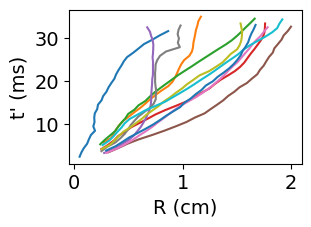

In [253]:
#plot alignment
fig,ax=plt.subplots(figsize=(3,2))
for index_pairs,row in df_P.iterrows():
    df=df_R[df_R['index_pairs']==index_pairs]
    d=df.sort_values(by='tdeath').head(30)
    x_values=d[R_col].values
    y_values=d['tdeath_align'].values
    #plot alignment
    plt.plot(x_values,y_values)
format_plot(ax=plt.gca(),xlabel='R (cm)', ylabel="t' (ms)",fontsize=14)
plt.show()

In [ ]:
# fig,ax=plt.subplots()
# for i,pid in enumerate(pid_lst_stumps):
#     dd=traj[traj[pid_col]==int(pid)]
#     dd.plot.scatter(x='x',y='y',ax=ax,color=f"C{i}")
# plt.show()

In [150]:
# #DONE: ROOT CAUSE ANALYSIS on why the lengths of 9/10 trajectories have only two data points
# #DONE: plot all spiral tip positions with fewer than 5 counts to their pair
# # # dfr.head()
# fig,ax=plt.subplots()
# for i,pid in enumerate(pid_lst_stumps):
#     dd=traj[traj[pid_col]==int(pid)]
#     dd.plot.scatter(x='x',y='y',ax=ax,color=f"C{i}")
# plt.show()
# #TODO(?): plot the annihilation partner with the shortest lifetime

In [ ]:
# fig, ax = plt.subplots(figsize=(4,4))
# #DONE: plot raw locations
# df_log.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# #DONE: plot trajectories
# # traj.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# format_plot(ax=ax,xlabel='x (pixels)',ylabel='y (pixels)')
# plt.show()

# TODO: boostrap xy values to compute MSR(t')

In [506]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [546]:
##########################
# GOAL: Compute MSR(t')
##########################
R_col='R_nosavgol'
# R_col='R'
T_col='tdeath_align'
# T_col='tdeath'

In [547]:
# dict_msr.keys()


In [548]:
SR_values_lst=[]
tau_values_lst=[]
count_events=0
for dict_msr in dict_msr_lst:
    #recall the data values
    df_R=dict_msr['df_R']
    SR_values=df_R[R_col].values**2
    tau_values=df_R[T_col].values
    #count the number of events
    num_events=df_R['index_pairs'].drop_duplicates().values.shape[0]

    #remove any null values
    boo_nan=np.isnan(tau_values)#tdeath_align has 6/1700 data points as null
    boo_nan|=np.isnan(SR_values)
    SR_values=SR_values[~boo_nan].copy()
    tau_values=tau_values[~boo_nan].copy()

    #record
    SR_values_lst.append(SR_values)
    tau_values_lst.append(tau_values)
    count_events+=num_events
SR_values=np.concatenate(SR_values_lst)
tau_values=np.concatenate(tau_values_lst)

    
    
num_trials=len(SR_values_lst)
num_obs=SR_values.shape[0]
print(f"aggregated N''={num_obs} R(t') observations from N'={num_trials} termination events. this involved N={count_events} pair-annihilation events.")
# num_trials,len(tau_values_lst),num_obs,tau_values.shape[0] #they're the same

aggregated N''=984939 R(t') observations from N'=577 termination events. this involved N=27696 pair-annihilation events.


In [549]:
#DONE: investigate which parameter setting needs to be changed to make df_smoothed mapping to dfr have dfr with {num_particles/2=}, {num_pairs=}
#DONE: wrap up to here into 1-3 functions for a dask.bag routine
#DONE: wrap routine as func foo
#DONE: eval_routine
#TODO: plot the MSR, as before
#heretimheretim

In [550]:
# if printing:
#     print(f"removed {sum(boo_nan)} data points due to having null x-value (or y-value)") #~6 per 1700 removed bc of alignment of time
assert not np.isnan(SR_values).any() and not np.isnan(tau_values).any()
SR_values.shape,tau_values.shape

((984939,), (984939,))

In [551]:
np.max(tau_values)

161.57694707168534

In [553]:
#compute bootstrap 
x_values_in=tau_values
y_values_in=SR_values
# bins='auto'
bins=np.arange(0,200,1)
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                               y_values_in,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=None,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
df_bootstrap.head()

tdeath_avg       MSR  Delta_tdeath_avg  Delta_MSR  p_tdeath_avg     p_MSR  \
0    2.760628  0.092384          0.004244   0.001426      0.814711  0.057715   
1    3.649537  0.115794          0.004168   0.001482      0.798826  0.425815   
2    4.607775  0.151028          0.003371   0.001694      0.764488  0.349283   
3    5.509449  0.155773          0.003792   0.001590      0.167368  0.946909   
4    6.501053  0.197168          0.003966   0.002046      0.738143  0.454847   

   counts  
0    4039  
1    9809  
2   13848  
3   16156  
4   15579

In [554]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((147,), (147,), (147,))

Does this appear to intersect at zero?


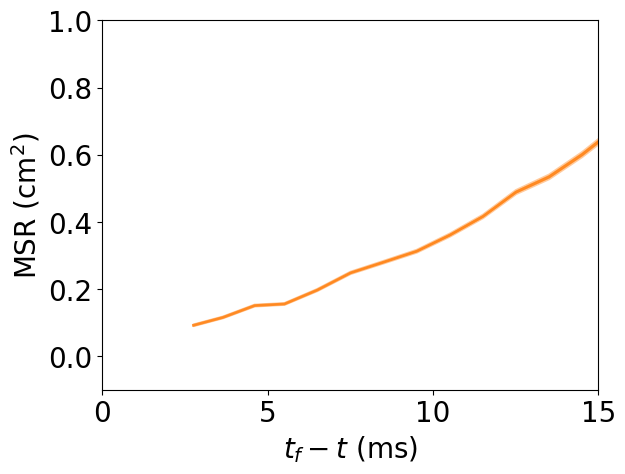

In [555]:
print(f"Does this appear to intersect at zero?")
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,15])
plt.ylim([-.1,1])
plt.show()

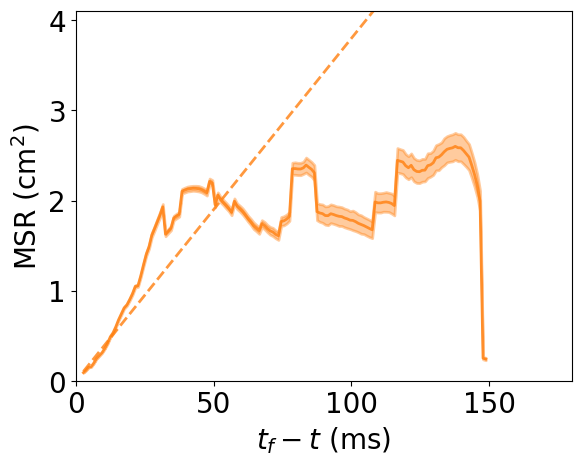

In [556]:
#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# plt.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,180])
plt.ylim([0,4.1])
plt.show()

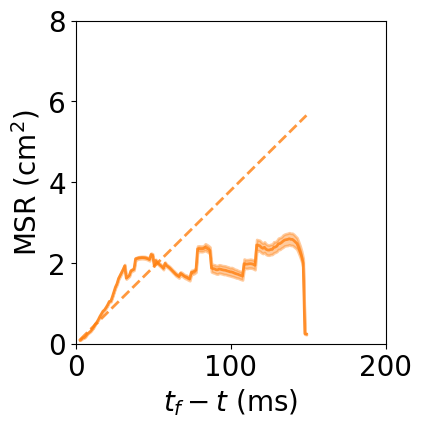

In [557]:
#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
ax.set_ylim([0,8])
plt.show()

# visualize the msr, compute its autocorrelation period, and save the analogas msr_lr_bootstraped file using wouter's data
- HINT: this was copied from src: #http://localhost:8890/notebooks/tests%20for%20screening%20via%20density%20dependence%20of%20attraction%20coefficients.ipynb


In [ ]:
from scipy import signal
from scipy.signal import argrelextrema

tmax=300
sig = y_values-4*1.6*1e-3*x_values
boo=x_values<tmax
DT=np.diff(x_values)[0]
sig=sig[boo].copy()
corr = signal.correlate(sig, sig)
lags = signal.correlation_lags(len(sig), len(sig))
corr /= np.max(corr)

# for local_maxima
local_maxima=argrelextrema(corr, np.greater)

# for local_minima
local_minima=argrelextrema(corr, np.less)

#TODO: find period of MSR before death
taumax_values=DT*lags[local_maxima]
taumin_values=DT*lags[local_minima]
np.diff(taumin_values),np.diff(taumax_values)

print(f"Periods of Autocorrelation of MSR (ms):")
print(np.diff(taumax_values))
yv=np.linspace(0,1,20)
for taumax in taumax_values:
    plt.plot(taumax+0.*yv,yv,'k--',alpha=0.5,lw=2)
    
plt.plot(DT*lags,corr,lw=2)
format_plot(ax=plt.gca(),xlabel=r'$\tau$ (ms)',ylabel=r'Autocorr. of MSR')
plt.show()

# # tmax=8#ms
# tmax=1e3#ms
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_SR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s")
print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

#DONE: record ^this in .odg
#DONT: does R values have units of cm when it is saved?  maybe I'm missing a scale of 5/200???^2???
#DONE: repeat with all samples!
#TODO: repeat with more/less smoothingi
1

#save as .csv
# modname='msr_fk'
# # modname='msr_lr'
save_folder=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results"
os.listdir(save_folder)
msr_csv_fn=f"{modname}_boostrapped_tavg2_{tavg2:.1f}_n_{max_num_groups}_a_{a_SR:.1f}_tmax_{tmax}.csv"
msr_csv_dir=os.path.join(save_folder,msr_csv_fn)
# df_bootstrap.to_csv(msr_csv_dir,index=False)
msr_csv_dir

beep(4)

#plot a versus t_f-t using (i) finite diff and (ii) using savgol
xmid_values=0.5*(x_values[1:]+x_values[:-1])
dydx_values=np.diff(y_values)/np.diff(x_values)
xmid_values=moving_average(xmid_values,4)
dydx_values=moving_average(dydx_values,4)
plt.plot(xmid_values,dydx_values/4*1e3,c=c)

#plot expected
plt.plot(x_values,9.5+0.*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,1.6+0.*x_values,'--',lw=2,alpha=0.8,c='C0')

format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'a (cm$^2$/s)')
plt.xlim([0,1000])
plt.show()

#plot expected
plt.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
plt.plot(x_values,4*1.6*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

beep(3)

#TODO: repeat for FK model

#TODO: save df_Ri
df_Ri.head()

# (ignore) the previous version to compute MSR (i think)

In [ ]:
##########################
# Compute MSR
##########################
R_col='R_nosavgol'

# R_col='R'

In [ ]:
minnumobs=8
#fenton karma msr dataframe
groups=dfr.groupby('tdeath')
tdeath_lst=[]
avg_lst=[]
stderror_lst=[]
sqavg_lst=[]
sqstderror_lst=[]
count_lst=[]
for n,g in groups:
    ##DONE: print each tdeath value 
    # print(n)
    gr=g[R_col]
    counts=gr.count()#.values
    if (minnumobs<=counts).all():
        #TODO: compute average and stderror of each group of tdeath
        avg=gr.mean()#.values
        stddev=gr.std()#.values
        stderror=stddev/np.sqrt(counts)
        
        #TODO: compute squared average
        sq=gr**2
        sqavg=sq.mean()#.values
        sqstddev=sq.std()#.values
        sqstderror=sqstddev/np.sqrt(counts)
        #record
        tdeath_lst.append(n)        
        avg_lst.append(avg)
        stderror_lst.append(stderror)
        sqavg_lst.append(sqavg)
        sqstderror_lst.append(sqstderror)
        count_lst.append(counts)
        
#collect each field into a pandas.DataFrame
df_msr=pd.DataFrame({
    'tdeath':tdeath_lst,
    'avg':avg_lst,
    'stderror':stderror_lst,  
    'sqavg':sqavg_lst,
    'sqstderror':sqstderror_lst,  
    'counts':count_lst
})    

In [ ]:
df_msr.sort_values(by='tdeath',inplace=True)
x_values=df_msr['tdeath'].values
y_values=df_msr['sqavg'].values**.5
yerr_values=df_msr['sqstderror'].values

In [ ]:
xmin=0#.1
xmax=150
# c='C1'
c='k'
#plot ^those resulting df_msr versus tdeath
plt.plot(x_values,y_values,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,color=c,alpha=0.5)
# plt.plot(x_values_lr,y_values_lr,c='C1')
# plt.fill_between(x_values_lr,y_values_lr-yerr_values_lr,y_values_lr+yerr_values_lr,color='C1',alpha=0.5)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',use_loglog=False)
plt.xlim([xmin,xmax])
xv=np.linspace(xmin,xmax,100)
# plt.plot(xv,xv*4*1.6*1e-3,'C0--',lw=2,alpha=0.7)
plt.plot(xv,xv*4*(9.4+2*0.58)*1e-3,'C1--',lw=2,alpha=0.7)
# plt.xlim([0,1])
plt.ylim([0,2])
# plt.ylim([0.5,2])
fontsize=16
# plt.legend(fontsize=fontsize-4,loc='upper right')
plt.title('_Results from Evaluation of the Full Model_\nDotted Lines indicate the Linear Particle Model with Diffusion\n',fontsize=fontsize)
plt.show()
print(f'R_col={R_col}, tavg1={tavg1} ms, tavg2={tavg2} ms')

In [ ]:
# HINT: was ^that in bgmc?

In [ ]:
# #GOAL: compute the msr_values simply without any kind of smoothing, and plot with the computed msr_values
# # option 1: turn off smoothing in generation of df
# bins=np.arange(0,2000)
# tau_values=0.5*(bins[:-1]+bins[1:])
# #TODO: bin and bootstrap dfr, as before
#TODO: plot the two methods of computing msr_values. compare. share with WJ.

In [ ]:
# #TODO: compute msr_values from df_annihilations, as before, with smoothing


In [ ]:
#DONT: plot the same example R_values with and without smoothing
#NOTE: it looks like i didn't use any smoothing

In [ ]:
# DONE(bonus): FlowerPlot the trajectories before/after smoothing
#HINT: unwrap traj, as before
# #HINT for unwrapping trajectories
# pid_lst = sorted(set(df[pid_col].values))
# #(duplicates filtered earlier_ _  _ _ ) filter_duplicate_trajectory_indices is slow (and can probs be accelerated with a sexy pandas one liner)
# pid_lst_filtered = pid_lst#filter_duplicate_trajectory_indices(pid_lst,df)
# # pid_lst_filtered = filter_duplicate_trajectory_indices(pid_lst,df)
# df = pd.concat([unwrap_traj_and_center(df[df[pid_col]==pid], width, height, DS, **kwargs) for pid in pid_lst_filtered])

In [ ]:
#DONE: view trajectories
# fig, ax = plt.subplots(figsize=(4,4))
# #DONE: plot raw locations
# #DONE: plot trajectories
# #DONE: plot smoothed trajectories
# # df_log.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# df.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# # traj.tail(200).plot.scatter(x='x',y='y',c='t',ax=ax)
# format_plot(ax=ax,xlabel='x (pixels)',ylabel='y (pixels)')
# plt.show()

#DONE: find annihilation pairs, as before
#DONE: compute df_annihilations, as before
# #TODO(later): save as .csv
##HINT:
# log_dir=os.path.abspath(input_fn)+'_log.csv'
# df_loc.to_csv(log_dir,index=False)

In [ ]:
#TODO: record
#TODO: format output
# #(optional) drop all feature columns that are not relevant here
# col_drop_lst=set(df.columns).difference(col_keep_lst)
# df.drop(columns=col_drop_lst,inplace=True)
# if printing:
#     print(f"features dropped: {col_drop_lst}")
#     print(f"note: ^these can be recovered using the index")

#TODO: save msr_values, as before
#TODO: save dfr and df_pairs

# scratchwerk

In [ ]:
#DONT: # option 2: implement it fresh
# #TODO: compute the R_values,tau_values simply without any kind of smoothing, and plot with the computed msr_values
# # #TODO: compute smoothed msr, as before
# R_lst=[]
# tau_lst=[]
# for d in df_annihilations.iterrows():
#     pass
# #for each row of df_annihilations, compute subtract_pbc  
# #HINT: subtract the values
# # #HINT for subtracting two points
# # subtract_pbc=get_subtract_pbc(width=width,height=height)
# # w=subtract_pbc(point,segment[0])


In [ ]:

# #infer filesystem for saving functionally from inputs
# trgt='_tavg'
# tavg1=float(eval(input_fn[input_fn.find(trgt)+len(trgt):].split('/')[0].split('_')[-1]))
# ext = f'_annihilations_denoised.csv'
# folder_ext=f'_tavg1_{tavg1}_tavg2_{tavg2}_maxdtmax_{max_dtmax_thresh}_maxRfin_{max_Rfinal_thresh}_mindur_{min_duration_thresh}'
# save_fn = os.path.basename(input_fn).replace('.csv', ext)

# if save_df_pairs:
#     #save df_pairs data from input_fn in dfr
#     save_folder = os.path.dirname(
#         os.path.dirname(input_fn)
#     ) + f'/pairs'+folder_ext
#     if not os.path.exists(save_folder):
#         os.mkdir(save_folder)
#     os.chdir(save_folder)
#     df_pairs.reset_index().to_csv(save_fn,index=False)
#     # pairs_dir = os.path.join(save_folder, save_fn)
#     pairs_dir = os.path.abspath(save_fn)

# #save dfr data from input_fn in dfr
# save_folder = os.path.dirname(
#     os.path.dirname(input_fn)
# ) + f'/smoothed_annihilations'+folder_ext
# if not os.path.exists(save_folder):
#     os.mkdir(save_folder)
# os.chdir(save_folder)
# dfr.reset_index().to_csv(save_fn,index=False)
# # dfr_dir = os.path.join(save_folder, save_fn)
# dfr_dir = os.path.abspath(save_fn)

In [ ]:
#DONE: see if the gpu-accelerated version works, as before
#DONT(later): make a cpu version of the unwrapping pipeline 
#HINT: i have unwrapping working on cpu, not sure about moving_avg_pbc
# #DONT: use the gpu version for all these mini-termination events
# # from lib.rapids_func.utils.unwrap_and_smooth_cu import apply_unwrap_xy_trajectories_pbc, apply_moving_avg_xy_trajectories
# #DONT: move to lib in lib.utils.unwrap_and_smooth.py
# def apply_unwrap_xy_trajectories_pbc_serial(df,t_col,pid_col,width,height,**kwargs):
#     #now we only have good data...  we can compute moving averages for each particle!
#     #allocate memory
#     df['dx_unwrap']=0.*df['x']
#     df['dy_unwrap']=0.*df['y']
#     df['x_unwrap']=df['x']
#     df['y_unwrap']=df['y']
#     #TODO(optional): reset the index... not needed and ruins reconstruction of dropped columns at the end...  don't do it...
#     # df.reset_index(inplace=True)
#     #apply unwrapping to x and y
#     df['incol']=df['x']
#     grouped = df.groupby(pid_col)
#     uwargs={'jump_thresh':width/2,"width":width}
#     df = grouped.apply(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                uwargs)
#     df['dx_unwrap']=df['outcol']

#     df['incol']=df['y']
#     grouped = df.groupby(pid_col)
#     uwargs={'jump_thresh':height/2,"width":height}
#     df = grouped.apply(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                uwargs)
#     df['dy_unwrap']=df['outcol']

#     df.drop(columns=['incol','outcol'],inplace=True)

#     #DONE: confirmed ^that was nontrivial and reasonable looking
#     # (df['dx_unwrap']!=0).any(),(df['dy_unwrap']!=0).any()
#     # df[df['dx_unwrap']!=0].head()
#     # (True,True)

#     #aggregte over jumps
#     grouped_unwrap=df.groupby(pid_col)

#     #aggregate along a given columns in grouped_unwrap
#     result=grouped_unwrap[['dx_unwrap','dy_unwrap']].cumsum()

#     #map result back onto df using reindexing ninjitsu
#     cp_col_lst=['dx_unwrap','dy_unwrap']
#     df.reset_index(inplace=True)
#     result.reset_index(inplace=True)
#     for col in cp_col_lst:
#         df[col]=result[col]
#     df.set_index('index',inplace=True)

#     #compute unwrapped coordinates
#     df['x_unwrap']=df['x']+df['dx_unwrap']
#     df['y_unwrap']=df['y']+df['dy_unwrap']
#     return df

# def apply_moving_avg_xy_trajectories_serial(df,t_col,pid_col,navg1,x_col='x_unwrap',y_col='y_unwrap',**kwargs):
#     diffx_col='diff'+x_col
#     diffy_col='diff'+y_col
#     #apply smoothing to x and y after unwrapping
#     df['incol']=df[x_col]
#     grouped = df.groupby(pid_col)
#     if navg1>0:
#         mawargs={'win_size':navg1}
#         df = grouped.apply(rolling_avg,
#                                        incols=['incol'],
#                                        outcols=dict(outcol=np.float64), kwargs=
#                                    mawargs)
#         df[x_col]=df['outcol']

#         df['incol']=df[y_col]
#         grouped = df.groupby(pid_col)
#         df = grouped.apply(rolling_avg,
#                                        incols=['incol'],
#                                        outcols=dict(outcol=np.float64), kwargs=
#                                    mawargs)
#         df[y_col]=df['outcol']
#     # else:
#     #     #perform no moving average if the window is of size zero
#     #     pass
#     # #drop data that isn't needed anymore
#     #DONE: verified that dropping data here doesn't affect the number of final nonnan values
#     # df.drop(columns=['incol','outcol'],inplace=True)
#     df.dropna(inplace=True)
#     # df.head()

#     #apply smoothing to x and y after unwrapping
#     df['incol']=df[x_col]
#     grouped = df.groupby(pid_col)
#     mdwargs={'win_size':2}
#     df = grouped.apply(rolling_diff,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                mdwargs)
#     df[diffx_col]=df['outcol']

#     df['incol']=df[y_col]
#     grouped = df.groupby(pid_col)
#     df = grouped.apply(rolling_diff,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), kwargs=
#                                mdwargs)
#     df[diffy_col]=df['outcol']

#     #drop data that isn't needed anymore
#     df.drop(columns=['incol','outcol'],inplace=True)
#     # df.dropna(inplace=True)

#     #compute the naive speed of the unwrapped trajectories in pixels per frame
#     df['speed']=cp.sqrt(df[diffx_col]**2+df[diffy_col]**2)#pixels per frame
#     # df['speed']=cp.sqrt(df['diffx_unwrap']**2+df['diffy_unwrap']**2)#pixels per frame#*DS/DT*10**3 #cm/s

#     # #DONE: test and verify that the largest stepsize in the unwrapped xy is reasonable for both x and y
#     # max_speed_values=df.groupby(pid_col)['speed'].max().values
#     # plt.hist(max_speed_values.get(),bins=30)
#     # plt.xlabel('max pixel displacement between two frames')
#     # max_speed_warning=20 #pixels per frame
#     # assert ((max_speed_values.get()<max_speed_warning).all())
#     # plt.show()
#     return df

# d = {"my_label": Series(['A','B','A','C','D','D','E'])}
# df = DataFrame(d)


# def as_perc(value, total):
#     return value/float(total)

# def get_count(values):
#     return len(values)

# # grouped_count = df.groupby("my_label").my_label.agg(get_count)
# grouped = df.groupby(pid_col)
# data = grouped.apply(unwrapper_pbc_serial, total=df.my_label.count())

# def unwrapper_pbc_serial(incol, jump_thresh, width):
#     '''
#     Example Usage: for cudf.DataFrame instance
#     df['incol']=df['x']
#     grouped = df.groupby(pid_col)
#     df = grouped.apply_grouped(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), jump_thresh=width/2)
#     df['dx_unwrap']=df['outcol']
#     df.head()
#     '''

# def unwrapper_pbc(incol, outcol, jump_thresh, width):
#     '''
#     Example Usage: for cudf.DataFrame instance
#     df['incol']=df['x']
#     grouped = df.groupby(pid_col)
#     df = grouped.apply_grouped(unwrapper_pbc,
#                                    incols=['incol'],
#                                    outcols=dict(outcol=np.float64), jump_thresh=width/2)
#     df['dx_unwrap']=df['outcol']
#     df.head()
#     '''
#     e=incol
#     de_unwrap=outcol
#     #for i in range(cuda.threadIdx.x, len(e), cuda.blockDim.x):
#     for i in range(cuda.threadIdx.x, len(e), cuda.blockDim.x):
#         de_unwrap[i]=0
#         if i>0:
#             de=e[i]-e[i-1]
#             jump_plus=de<-jump_thresh
#             jump_minus=de>jump_thresh
#             if jump_plus:
#                 de_unwrap[i]=width
#             elif jump_minus:
#                 de_unwrap[i]=-width